In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

### Annotaions

In [2]:
# Load the annotations
annotations_train_path = 'data/processed_annotations_train.csv'
annotations_train = pd.read_csv(annotations_train_path)

annotations_val_path = 'data/processed_annotations_valid.csv'
annotations_val = pd.read_csv(annotations_val_path)

In [3]:
print(annotations_train.head())

                                       attachment_id text  \
0  data/tensors\train_9ede40ec-0c67-4a57-8337-003...    Н   
1  data/tensors\train_8fb4e5c9-a7df-4bad-b7d7-9d8...    Н   
2  data/tensors\train_d228da91-495a-4d6d-833a-64b...    Н   
3  data/tensors\train_397a486d-967f-444b-afd8-de1...    Н   
4  data/tensors\train_e1200d57-9b53-4ffa-ab7d-e3e...    Н   

                            user_id  height  width  length  train  
0  185bd3a81d9d618518d10abebf0d17a8    1920   1080    95.0   True  
1  46dd04a1caa75ed3082b573cb5a3ad26    1920   1080    37.0   True  
2  db573f94204e56e0cf3fc2ea000e5bdc    1280    720    45.0   True  
3  0211b488644476dd0fec656ccb9b74fc    1920   1080    52.0   True  
4  b07a773bcb10b4f14f33d2b0e8ec58ba     720   1280    69.0   True  


In [4]:
print(annotations_val.head())

                                       attachment_id text  \
0  data/tensors\valid_d1131f18-57d2-412f-8261-aca...    Н   
1  data/tensors\valid_016df4ed-6e78-40a1-974f-e5d...    Н   
2  data/tensors\valid_45557bda-2f3a-4882-a430-9cf...    Н   
3  data/tensors\valid_ab6ef8b7-1971-4218-ad0f-bfe...    Н   
4  data/tensors\valid_49d3d3c3-7288-4a05-96bf-76d...    Н   

                            user_id  height  width  length  train  
0  0ab4f8e463cdded2e59d6001f4e1b487    1080   1920    42.0  False  
1  1860c7f3605089bf0eff0c4e72c7add4    1440   1440    41.0  False  
2  7c989fdb633be7453228f7c650097205    1920   1080    30.0  False  
3  ba230d5b794c9a7350356eddd3e9929c    1920    960    41.0  False  
4  3dd2ce2659aada17b976390004ebe322    1920    886    39.0  False  


### Definition of custom dateset class with padding

In [5]:
class PaddedSignLanguageDataset(Dataset):
    def __init__(self, annotations, transform=None, max_length=None):
        """
        Custom dataset for loading sign language video tensors with padding.
        Each video tensor is padded to a uniform length for consistent processing.

        :param annotations (DataFrame): DataFrame containing the annotations.
        :param transform (callable, optional): Optional transform to be applied on a sample.
        :param max_length (int, optional): Maximum length of the video tensors. If not provided, it will be calculated.
        """
        self.annotations = annotations
        self.transform = transform
        self.max_length = 132

        if self.max_length is None:
            # Calculate the maximum length among all tensors
            self.max_length = max(len(torch.load(row['attachment_id'], map_location=torch.device('cpu'))) for _, row in annotations.iterrows())

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.annotations)

    def __getitem__(self, idx):
        """
        Returns the sample at the given index.

        :param idx (int): Index
        :return: Tuple of (video tensor, label)
        """
        tensor_path = self.annotations.iloc[idx]['attachment_id']
        label = self.annotations.iloc[idx]['text']
        
        # Load the tensor
        tensor = torch.load(tensor_path, map_location=torch.device('cpu'))
        
        # Debugging: Print tensor information
        # if isinstance(tensor, list):
        #     print(f"Tensor at Index {idx} is a list with length {len(tensor)}")
        #     if tensor:
        #         if tensor[0] is None or len(tensor[0]) == 0:
        #             print(f"Malformed tensor found at index {idx}.")
        #             return None, label
        #     else:
        #         print("Empty list.")
        # else:
        #     print(f"Tensor at Index {idx}: {tensor}")
        #     print(f"Tensor Shape: {tensor.shape if tensor else 'Empty Tensor'}")
        # print(f"Label: {label}")

        # Check if the tensor is empty or None
        if tensor is None or len(tensor) == 0:
            print(f"Empty tensor found at index {idx}.")
            return None, label


        # Pad the tensor to the maximum length
        padded_tensor = torch.zeros((self.max_length, *tensor[0].shape))
        padded_tensor[:len(tensor)] = torch.stack(tensor)
                
        # Apply transform if any
        if self.transform:
            padded_tensor = self.transform(padded_tensor)

        return padded_tensor, label

In [6]:
# Create the padded dataset and dataloader
padded_dataset_train = PaddedSignLanguageDataset(annotations_train)
padded_dataloader_train = DataLoader(padded_dataset_train, batch_size=4, shuffle=True)

padded_dataset_val = PaddedSignLanguageDataset(annotations_val)
padded_dataloader_val = DataLoader(padded_dataset_val, batch_size=4, shuffle=True)

In [7]:
# Display a sample from the padded dataset
for tensor, label in padded_dataloader_train:
    print("Sample tensor shape:", tensor.shape)
    print("Sample label:", label)
    break  # Display only the first batch

Sample tensor shape: torch.Size([4, 132, 3, 64, 64])
Sample label: ('Н', 'цветовой оттенок', 'вероятно', 'продлевать')


### Models definition

In [8]:
class Simple3DConvNet(nn.Module):
    def __init__(self, num_classes):
        """
        A simple 3D Convolutional Neural Network for video classification.
        Consists of two convolutional layers followed by two fully connected layers.

        :param num_classes (int): Number of classes for classification.
        """
        super(Simple3DConvNet, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(270336, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass of the network.

        :param x (Tensor): Input tensor of shape (batch_size, 3, max_length, 112, 112)
        :return: Output tensor of shape (batch_size, num_classes)
        """
        # print(x.shape)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
class TwoStream3DConvNet(nn.Module):
    def __init__(self, num_classes):
        super(TwoStream3DConvNet, self).__init__()
        """
        A two-stream 3D Convolutional Neural Network for video classification.
        This network processes spatial and temporal information separately and then combines them.

        :param num_classes (int): Number of classes for classification.
        """
        # Spatial Stream
        self.spatial_stream = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        # Temporal Stream
        self.temporal_stream = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(540672, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass of the network.

        :param x (Tensor): Input tensor of shape (batch_size, 3, max_length, 112, 112)
        :return: Output tensor of shape (batch_size, num_classes)
        """
        spatial_out = self.spatial_stream(x)
        temporal_out = self.temporal_stream(x)
        
        # Concatenate the outputs of the two streams
        combined = torch.cat((spatial_out, temporal_out), dim=1)
        
        combined = torch.flatten(combined, 1)
        combined = self.relu(self.fc1(combined))
        combined = self.fc2(combined)
        return combined

In [10]:
class ResNet3D(nn.Module):
    def __init__(self, num_classes):
        """
        A 3D version of the ResNet architecture for video classification.
        This network utilizes residual connections for deep feature learning.

        :param num_classes (int): Number of classes for classification.
        """
        super(ResNet3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        
        # Residual Layers
        self.residual_layers = nn.Sequential(
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        )
        
        self.fc = nn.Linear(2162688, num_classes)

    def forward(self, x):
        """
        Defines the forward pass of the 3D ResNet.

        :param x: Input tensor representing a batch of video sequences.
        :return: Output tensor with classification scores.
        """
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        
        # Residual Layers
        residual = x
        x = self.residual_layers(x)
        x += residual
        
        # print(x.shape)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [11]:
num_classes = len(set(annotations_train['text']))

models = {
    'simple_3d_conv_net': Simple3DConvNet(num_classes),
    'two_stream_3d_conv_net': TwoStream3DConvNet(num_classes),
    'resnet3d': ResNet3D(num_classes)
}

### Labels Mapping

In [12]:
# Initialize an empty set to collect unique labels
unique_labels_train = set()

# Iterate over your dataset to collect unique labels
for _, label_data in padded_dataloader_train:
    unique_labels_train.update(label_data)

# Sort the labels for consistency
sorted_labels = sorted(unique_labels_train)

# Create the label mapping
train_label_mapping = {label: idx for idx, label in enumerate(sorted_labels)}

# Print the label mapping
print("Label Mapping:", train_label_mapping)

Label Mapping: {'Н': 0, 'вероятно': 1, 'значить': 2, 'обычный': 3, 'овца': 4, 'продлевать': 5, 'суматоха': 6, 'такой': 7, 'цветовой оттенок': 8, 'черный': 9}


In [13]:
# Initialize an empty set to collect unique labels
unique_labels_test = set()

# Iterate over your dataset to collect unique labels
for _, label_data in padded_dataloader_val:
    unique_labels_test.update(label_data)

# Sort the labels for consistency
sorted_labels = sorted(unique_labels_test)

# Create the label mapping
val_label_mapping = {label: idx for idx, label in enumerate(sorted_labels)}

# Print the label mapping
print("Label Mapping:", val_label_mapping)

Label Mapping: {'Н': 0, 'вероятно': 1, 'значить': 2, 'обычный': 3, 'овца': 4, 'продлевать': 5, 'суматоха': 6, 'такой': 7, 'цветовой оттенок': 8, 'черный': 9}


### Train and Validation loops

In [14]:
# Loss function
criterion = nn.CrossEntropyLoss()

num_epochs = 5
results = {}

# Train the models
# Training and Validation
for model_name, model in models.items():
    print(f"Training {model_name}")

    # Loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # List to store epoch-wise validation accuracies for the current model
    epoch_val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Training Phase
        model.train()
        loop = tqdm(enumerate(padded_dataloader_train, 0), total=len(padded_dataloader_train), desc=f"Epoch {epoch+1}/{num_epochs} - Training")
        for i, data in loop:
            inputs, label_data = data
            labels = torch.tensor([train_label_mapping[label] for label in label_data], dtype=torch.long)
            inputs = inputs.permute(0, 2, 1, 3, 4)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update progress bar
            loop.set_description(f"Epoch {epoch+1}/{num_epochs} - Training")
            loop.set_postfix(loss = running_loss / (i+1), accuracy = correct_predictions / total_predictions)

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        loop_val = tqdm(enumerate(padded_dataloader_val, 0), total=len(padded_dataloader_val), desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
        for i, data in loop_val:
            inputs, label_data = data

            if len(inputs) == 0 or len(label_data) == 0:
                continue

            labels = torch.tensor([val_label_mapping.get(label) for label in label_data], dtype=torch.long)
            inputs = inputs.permute(0, 2, 1, 3, 4)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total_predictions += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()

            # Update progress bar
            loop_val.set_description(f"Epoch {epoch+1}/{num_epochs} - Validation")
            loop_val.set_postfix(loss = val_running_loss / (i+1), accuracy = val_correct_predictions / val_total_predictions)

        val_accuracy = val_correct_predictions / val_total_predictions
        epoch_val_accuracies.append(val_accuracy)

    # Store the epoch-wise validation accuracies for this model
    results[model_name] = epoch_val_accuracies

print('Finished Training')


Training simple_3d_conv_net


Epoch 5/5 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.91it/s, accuracy=0.18, loss=3.23] 


Training two_stream_3d_conv_net


Epoch 5/5 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s, accuracy=0.28, loss=3.6]  


Training resnet3d


Epoch 5/5 - Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s, accuracy=0.22, loss=9.86] 

Finished Training


### Plotting

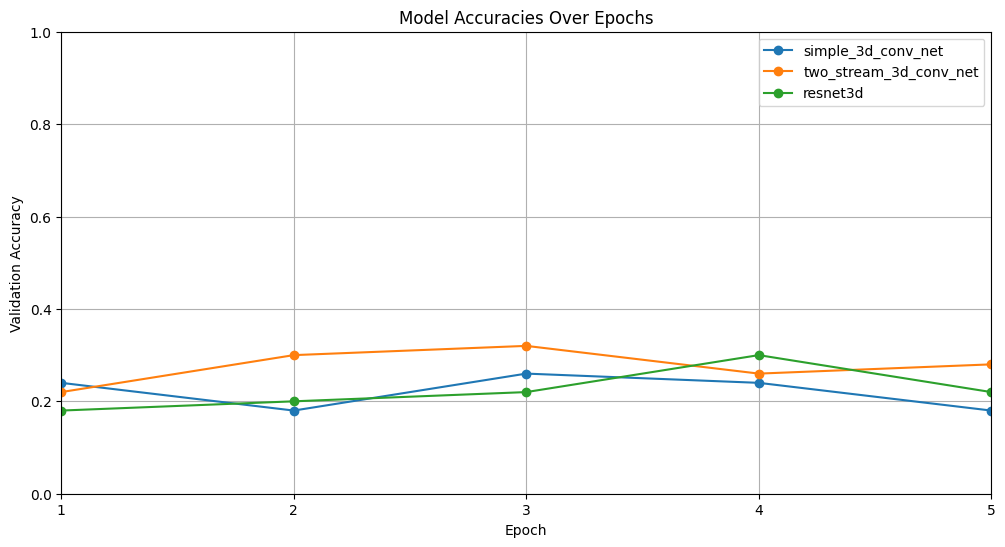

In [24]:
# Assuming results is a dictionary with model names as keys and lists of accuracies as values
model_names = list(results.keys())
num_epochs = range(1, len(next(iter(results.values()))) + 1)

plt.figure(figsize=(12, 6))

# Iterate over each model and plot a line graph of its accuracies
for model_name in model_names:
    plt.plot(num_epochs, results[model_name], label=model_name, marker='o')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Model Accuracies Over Epochs')
plt.xticks(num_epochs)
plt.xlim(1, len(num_epochs))
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

In [25]:
from scipy.stats import ttest_rel

def perform_ttest(accuracies_model_1, accuracies_model_2):
    """
    Perform a paired t-test on two sets of model accuracies.

    :param accuracies_model_1: Accuracies from the first model.
    :param accuracies_model_2: Accuracies from the second model.
    :return: t-statistic and p-value of the t-test.
    """
    t_stat, p_value = ttest_rel(accuracies_model_1, accuracies_model_2)
    return t_stat, p_value

In [26]:
# Statistical Test
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        model_1_name = model_names[i]
        model_2_name = model_names[j]
        
        accuracies_model_1 = results[model_1_name]
        accuracies_model_2 = results[model_2_name]
        
        t_stat, p_value = ttest_rel(np.array(accuracies_model_1), np.array(accuracies_model_2))
        
        if p_value < 0.05:
            print(f"{model_1_name} and {model_2_name} are significantly different (p={p_value:.3f}).")
        else:
            print(f"No significant difference between {model_1_name} and {model_2_name} (p={p_value:.3f}).")

No significant difference between simple_3d_conv_net and two_stream_3d_conv_net (p=0.094).
No significant difference between simple_3d_conv_net and resnet3d (p=0.871).
No significant difference between two_stream_3d_conv_net and resnet3d (p=0.114).
